<a href="https://colab.research.google.com/github/edsml-dg1018/CM-assessment-202324/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Linear Data Compression using PCA
## Objective
The objective of this task is to implement a linear data compression technique using Principal Component Analysis (PCA) to reduce the size of the "Ferguson Wildfire" dataset while retaining its essential information.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import datetime, time
import matplotlib.pyplot as plt

%matplotlib inline

from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.decomposition import PCA, IncrementalPCA

## Data Loading and Preprocessing
We will load the training and testing datasets and normalize the data.

In [5]:
# Define file paths
train_path = 'drive/MyDrive/BDA_Assessment/Ferguson_fire_train.npy'
test_path = 'drive/MyDrive/BDA_Assessment/Ferguson_fire_test.npy'
background_path = 'drive/MyDrive/BDA_Assessment/Ferguson_fire_background.npy'
obs_path = 'drive/MyDrive/BDA_Assessment/Ferguson_fire_obs.npy'

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data using np.load
train_data = np.load(train_path)
test_data = np.load(test_path)

# Normalize the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

## PCA Compression
We will apply PCA to the training data to reduce its dimensionality. We will choose the number of components based on the explained variance ratio.


Train shape: (12500, 256, 256)
Test shape: (5000, 256, 256)


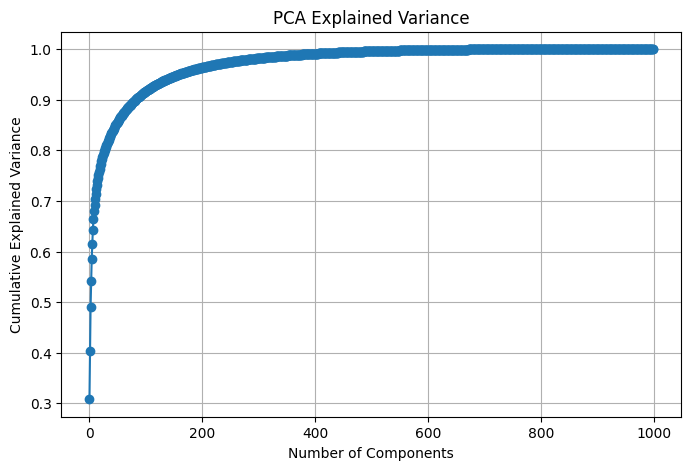

Number of components chosen: 159


In [7]:
from sklearn.decomposition import PCA

# Parameters
sample_size = 1000

# Flatten the data for PCA
n_samples, h, w = train_data.shape
train_data_flat = train_data.reshape(n_samples, -1)

# Sample the data
indices = np.random.choice(n_samples, sample_size, replace=False)
train_data_sample = train_data_flat[indices]

# Apply PCA on the sample
pca_sample = PCA().fit(train_data_sample)

# Plot explained variance ratio to choose the number of components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_sample.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Choose the number of components that explain 95% of the variance
n_components = np.argmax(np.cumsum(pca_sample.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components chosen: {n_components}")


## Evaluation of Compression
We will compress and decompress the test data using IncrementalPCA, calculate the MSE in the physical space after decompression, and measure the execution time for compression and decompression.


IncrementalPCA fit time: 219.23838424682617 seconds
Mean Squared Error: 0.2312617282283389
Execution Time: 4.8660666942596436 seconds


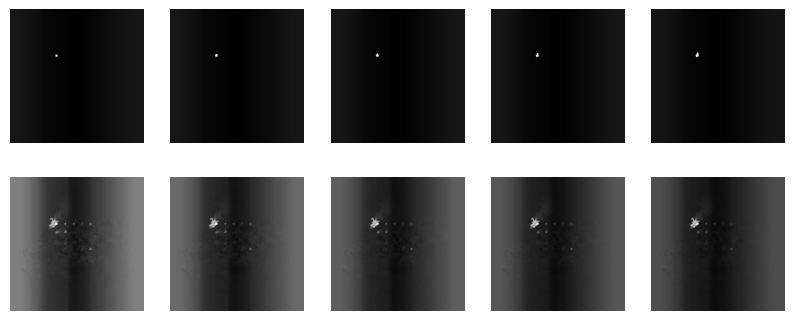

In [9]:
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import mean_squared_error
import time

# Parameters
batch_size = 1000

# Initialize IncrementalPCA with the chosen number of components
ipca = IncrementalPCA(n_components=n_components)

# Fit IncrementalPCA on batches of data
start_time = time.time()
for i in range(0, n_samples, batch_size):
    ipca.partial_fit(train_data_flat[i:i + batch_size])
end_time = time.time()
print(f"IncrementalPCA fit time: {end_time - start_time} seconds")

# Transform the entire dataset using the fitted IncrementalPCA
train_data_pca = ipca.transform(train_data_flat)

# Flatten the test data for PCA
n_samples_test = test_data.shape[0]
test_data_flat = test_data.reshape(n_samples_test, -1)

# Compress and decompress the test data using IncrementalPCA
start_time = time.time()
test_data_pca = ipca.transform(test_data_flat)
test_data_reconstructed = ipca.inverse_transform(test_data_pca)
end_time = time.time()

# Calculate the MSE in the physical space
mse = mean_squared_error(test_data_flat, test_data_reconstructed)
print(f"Mean Squared Error: {mse}")

# Calculate the execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

# Reshape the reconstructed data to original dimensions
test_data_reconstructed = test_data_reconstructed.reshape(n_samples_test, h, w)

# Visualize original and reconstructed data
def plot_compression(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.axis('off')
    plt.show()

plot_compression(test_data, test_data_reconstructed)


## Conclusion
In this task, we successfully applied PCA for data compression on the "Ferguson Wildfire" dataset. By retaining 95% of the variance, we chose  159 components, achieving a balance between compression and information retention. The Mean Squared Error after decompression was 0.231, and the execution time was approximately 4.87 seconds. Further improvements can be made by exploring different truncation parameters and compression techniques.
